# Indexing - Local Descriptors

In [ ]:
!pip install opencv-python opencv-contrib-python numpy matplotlib


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np

images_path = '/content/drive/MyDrive/BE'
images = [cv2.imread(os.path.join(images_path, f), cv2.IMREAD_GRAYSCALE) for f in os.listdir(images_path) if f.endswith('.jpg')]


# I- Calculation of Interest Points:

### 1- Harris Detector:

In [ ]:
def detect_harris_corners(image, block_size=2, ksize=3, k=0.04):
    img_copy = image.copy()


    gray = np.float32(img_copy)
    dst = cv2.cornerHarris(gray, block_size, ksize, k)


    dst = cv2.dilate(dst, None)
    img_copy[dst > 0.01 * dst.max()] = 255

    return img_copy, dst

- The function cv2.dilate(dst, None) applies a dilation operation on the image of detected corners (dst). This makes the corner areas larger and more visible, facilitating their visual identification.
- Then, the condition img_copy[dst > 0.01 * dst.max()] = 255 replaces the pixels in the image where the corner detector's response (dst) is greater than 1% of the maximum value of the detected corners. These pixels are then set to white (255), visually marking the corners on the image.

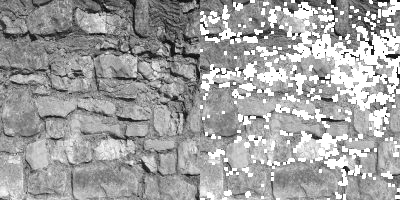

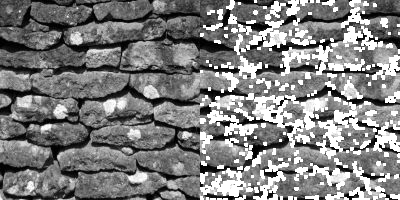

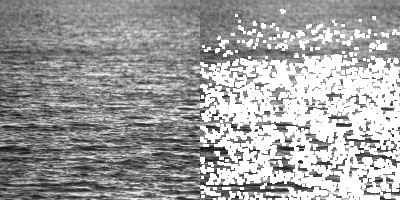

In [ ]:
for i, img in enumerate(images):
    img_with_corners, corners = detect_harris_corners(img)


    if i < 3:
        concatenated = np.hstack((img, img_with_corners))
        cv2_imshow(concatenated)

1. **Stone walls:** The Harris corner detector detects a large number of corners and sharp edges, especially in areas where the stones are well-defined and where there are marked transitions between the different surface textures **(the corners of the stones, the intersections between the different elements of the wall)**.
2. The **sea** exhibits a marked texture with strong corner detection, due to the fact that the surface of the water in the image has **repetitive patterns or structures that create sharp contrast variations (waves)**.

### 2- SIFT Detector:

In [ ]:
def detect_sift_keypoints(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_with_keypoints, keypoints,descriptors

cv2.drawKeypoints with **flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS**:
This flag adds more detailed visual information about the keypoints: the circles display the size and direction of the interest points, providing a more complete visualization of the detected features.

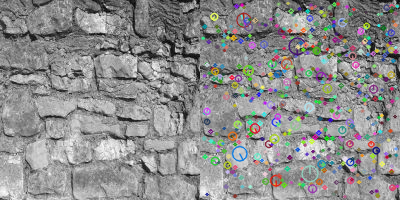

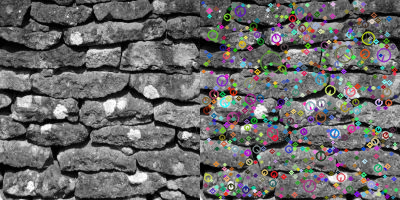

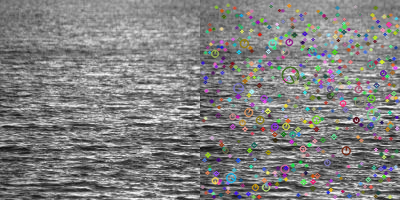

In [ ]:
sift_descriptors_list = []
for i, img in enumerate(images):
    img_with_keypoints, keypoints,descriptors = detect_sift_keypoints(img)
    sift_descriptors_list.append(descriptors)
    if i < 3:

        img_colored = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        concatenated = cv2.hconcat([img_colored, img_with_keypoints])
        cv2_imshow(concatenated)

#II- Calculation of the associated descriptors:

### 1- SIFT

The descriptors are calculated using the function **detect_sift_keypoints** and are stored in **sift_descriptors_list**.

### 2- Differential Invariants

In [ ]:
def compute_gradients(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    return grad_x, grad_y

def compute_descriptors(image, block_size=5):
    grad_x, grad_y = compute_gradients(image)

    descriptors = []

    for i in range(0, image.shape[0] - block_size, block_size):
        for j in range(0, image.shape[1] - block_size, block_size):
            block_grad_x = grad_x[i:i+block_size, j:j+block_size]
            block_grad_y = grad_y[i:i+block_size, j:j+block_size]

            energy = np.sum(np.abs(block_grad_x)) + np.sum(np.abs(block_grad_y))
            descriptors.append(energy)

    return np.array(descriptors)

The calculation of descriptors is done by dividing the image into blocks of size block_size. For each block, the **horizontal gradients Gx and vertical gradients Gy** are extracted using the **Sobel filter**. Then, the energy of the block is calculated by summing the absolute values of these gradients across all the pixels in the block, which gives a descriptor representing the intensity of changes within that block.

In [ ]:
for i, img in enumerate(images):
  differential_invariants_descriptors = compute_descriptors(img_with_corners)

# III- Data Augmentation (rotation,transaltion,zoom,contraste)

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt


images_path = '/content/drive/MyDrive/BE'
augmented_folder = '/content/drive/MyDrive/BE/AugmentedDB'
if not os.path.exists(augmented_folder):
    os.makedirs(augmented_folder)

def rotate_image(image, angle):
    (h, w) = image.shape
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h))
    return rotated

def translate_image(image, tx, ty):
    matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return translated

def zoom_image(image, zoom_factor):
    h, w = image.shape
    zoomed = cv2.resize(image, (int(w * zoom_factor), int(h * zoom_factor)))
    return zoomed


def adjust_contrast(image, alpha):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

original_images = []
augmented_images = []


for i, img in enumerate(images):
    original_images.append(img)

    # Rotation
    rotated_img = rotate_image(img, angle=15)
    cv2.imwrite(os.path.join(augmented_folder, f'rotated_{i}.jpg'), rotated_img)
    augmented_images.append(rotated_img)

    # Translation
    translated_img = translate_image(img, tx=20, ty=20)
    cv2.imwrite(os.path.join(augmented_folder, f'translated_{i}.jpg'), translated_img)
    augmented_images.append(translated_img)

    # Zoom
    zoomed_img = zoom_image(img, zoom_factor=1.2)
    cv2.imwrite(os.path.join(augmented_folder, f'zoomed_{i}.jpg'), zoomed_img)
    augmented_images.append(zoomed_img)

    # Contraste
    contrasted_img = adjust_contrast(img, alpha=1.5)
    cv2.imwrite(os.path.join(augmented_folder, f'contrasted_{i}.jpg'), contrasted_img)
    augmented_images.append(contrasted_img)

print("Augmentation terminée et les images sont enregistrées dans", augmented_folder)

Augmentation terminée et les images sont enregistrées dans /content/drive/MyDrive/BE/AugmentedDB


We apply augmentation transformations as follows:

1. Rotation: 15 degrees
2. Translation: Shift by 20 pixels horizontally and vertically
3. Zoom: 1.2 times
4. Contrast enhancement: 1.5 times

# IV- Robustness of SIFT

In [ ]:
def compute_sift_descriptors(images):
    sift = cv2.SIFT_create()
    descriptors_list = []
    for img in images:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        descriptors_list.append(descriptors)
    return descriptors_list

original_descriptors = compute_sift_descriptors(original_images)
augmented_descriptors = compute_sift_descriptors(augmented_images)

In [ ]:
def compute_similarity_matrix(descriptors_list1, descriptors_list2):
    N1 = len(descriptors_list1)
    N2 = len(descriptors_list2)
    similarity_matrix = np.zeros((N1, N2))
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    for i in range(N1):
        for j in range(N2):
            if descriptors_list1[i] is not None and descriptors_list2[j] is not None:
                matches = bf.match(descriptors_list1[i], descriptors_list2[j])
                similarity_matrix[i, j] = len(matches)
    return similarity_matrix

In [ ]:
sift_similarity_matrix = compute_similarity_matrix(original_descriptors, augmented_descriptors)

In [ ]:
print(len(original_descriptors))
print(len(augmented_descriptors))

50
200


**Robustness Evaluation:** For each original image, it takes the maximum similarity value among the 4 augmentations associated with that image.

In [ ]:
def evaluate_robustness(similarity_matrix, num_originals):
    scores = []
    for i in range(num_originals):
        scores.append(similarity_matrix[i, i * 4:(i + 1) * 4].max())  # Each original image corresponds to 4 augmentations.
    return scores

robustness_scores = evaluate_robustness(sift_similarity_matrix, len(original_images))


print("Scores de robustesse pour chaque image originale :")
for i, score in enumerate(robustness_scores):
    print(f"Image {i+1}: Robustesse maximale = {score}")

Scores de robustesse pour chaque image originale :
Image 1: Robustesse maximale = 482.0
Image 2: Robustesse maximale = 647.0
Image 3: Robustesse maximale = 542.0
Image 4: Robustesse maximale = 721.0
Image 5: Robustesse maximale = 112.0
Image 6: Robustesse maximale = 42.0
Image 7: Robustesse maximale = 46.0
Image 8: Robustesse maximale = 265.0
Image 9: Robustesse maximale = 192.0
Image 10: Robustesse maximale = 544.0
Image 11: Robustesse maximale = 597.0
Image 12: Robustesse maximale = 883.0
Image 13: Robustesse maximale = 640.0
Image 14: Robustesse maximale = 258.0
Image 15: Robustesse maximale = 301.0
Image 16: Robustesse maximale = 73.0
Image 17: Robustesse maximale = 176.0
Image 18: Robustesse maximale = 466.0
Image 19: Robustesse maximale = 237.0
Image 20: Robustesse maximale = 67.0
Image 21: Robustesse maximale = 238.0
Image 22: Robustesse maximale = 359.0
Image 23: Robustesse maximale = 500.0
Image 24: Robustesse maximale = 504.0
Image 25: Robustesse maximale = 215.0
Image 26: Ro

### Interpretation

1. High Scores (over 500):
The images **2, 4, 12, 36**, and a few others show robust scores (for example, **647.0, 721.0, 883.0**). This indicates that these images have many stable feature points despite the transformations, suggesting that these images **contain rich and meaningful details** that allow the SIFT descriptors to match well after transformation.
Here are the images 2, 4, 12, 36 in question:

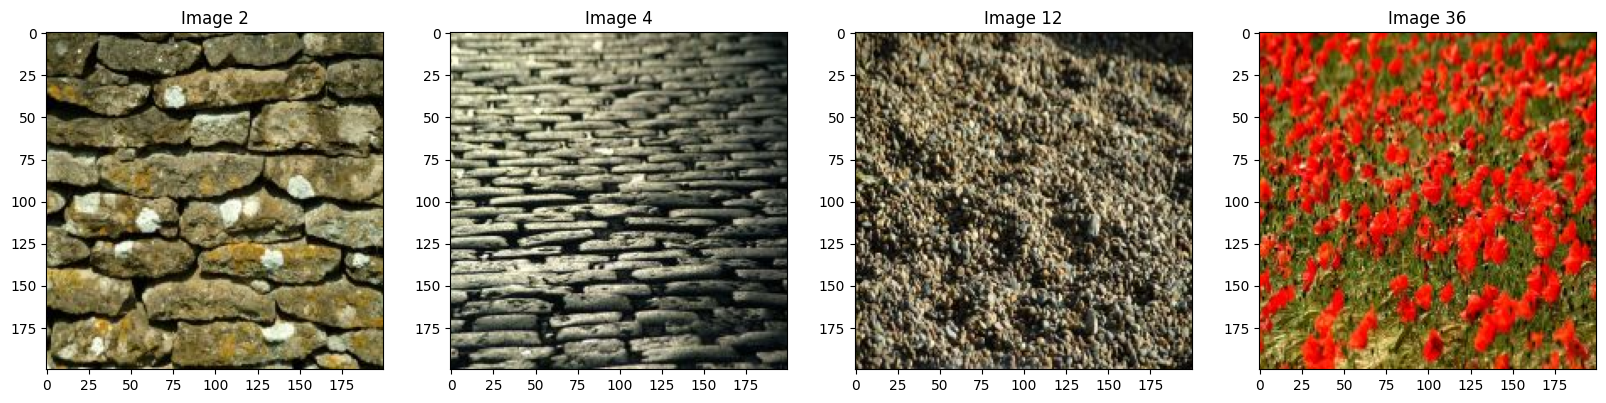

In [ ]:
import matplotlib.pyplot as plt

img2 = cv2.imread('/content/drive/MyDrive/BE/02.jpg')
img4 = cv2.imread('/content/drive/MyDrive/BE/04.jpg')
img12 = cv2.imread('/content/drive/MyDrive/BE/12.jpg')
img36 = cv2.imread('/content/drive/MyDrive/BE/36.jpg')

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img12 = cv2.cvtColor(img12, cv2.COLOR_BGR2RGB)
img36 = cv2.cvtColor(img36, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1), plt.imshow(img2), plt.title("Image 2")
plt.subplot(1, 4, 2), plt.imshow(img4), plt.title("Image 4")
plt.subplot(1, 4, 3), plt.imshow(img12), plt.title("Image 12")
plt.subplot(1, 4, 4), plt.imshow(img36), plt.title("Image 36")

plt.show()


2- **Medium Scores (between 100 and 500)**:
The images **5, 14, 32**, with scores of **112.0, 258.0, or 473.0**, show that the descriptors remain relatively robust, but with some sensitivity to transformations. Images in this range may contain **more variable details or may be slightly affected by the applied transformations**, but the key points are still largely recognized.

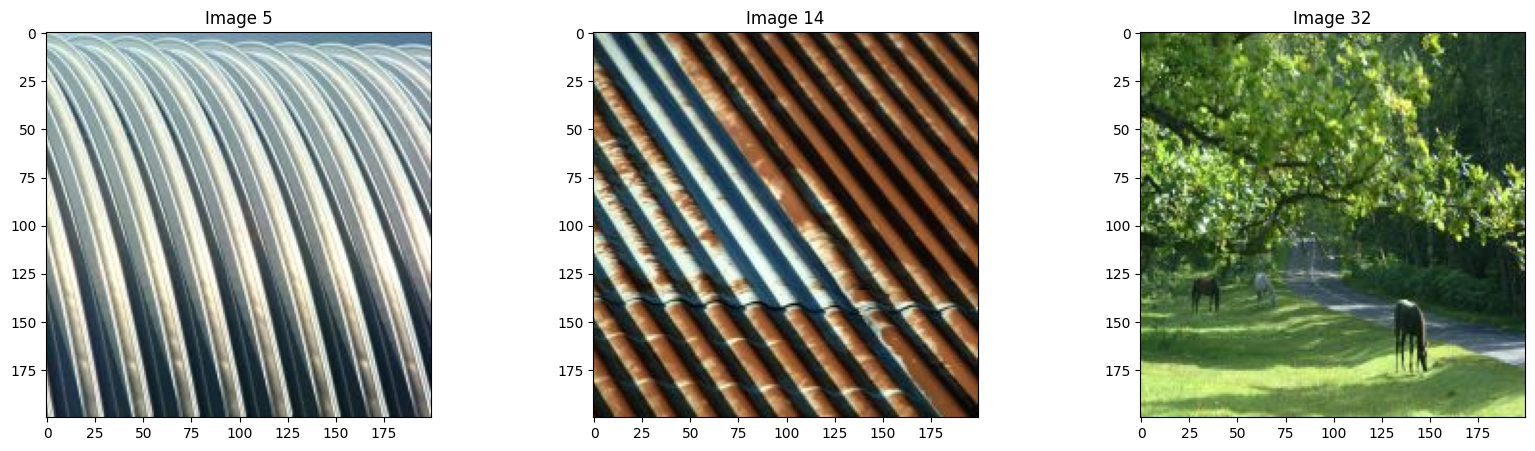

In [ ]:
img5 = cv2.imread('/content/drive/MyDrive/BE/05.jpg')
img14 = cv2.imread('/content/drive/MyDrive/BE/14.jpg')
img32 = cv2.imread('/content/drive/MyDrive/BE/32.jpg')

img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img14 = cv2.cvtColor(img14, cv2.COLOR_BGR2RGB)
img32 = cv2.cvtColor(img32, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1), plt.imshow(img5), plt.title("Image 5")
plt.subplot(1, 3, 2), plt.imshow(img14), plt.title("Image 14")
plt.subplot(1, 3, 3), plt.imshow(img32), plt.title("Image 32")


plt.show()

3- Low Scores (less than 100):

The images **6, 46, 47**, etc., have low scores, indicating **that the applied transformations (rotation, zoom, etc.) significantly disrupted the feature points**.

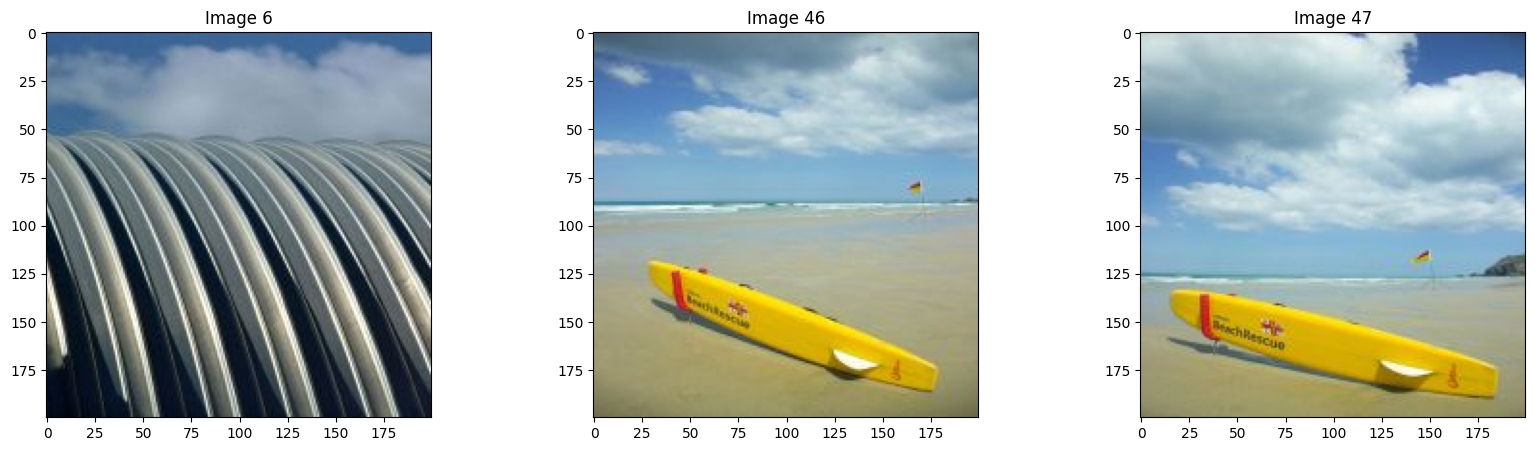

In [ ]:
img6 = cv2.imread('/content/drive/MyDrive/BE/06.jpg')
img46 = cv2.imread('/content/drive/MyDrive/BE/46.jpg')
img47 = cv2.imread('/content/drive/MyDrive/BE/47.jpg')

img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img46 = cv2.cvtColor(img46, cv2.COLOR_BGR2RGB)
img47= cv2.cvtColor(img47, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1), plt.imshow(img6), plt.title("Image 6")
plt.subplot(1, 3, 2), plt.imshow(img46), plt.title("Image 46")
plt.subplot(1, 3, 3), plt.imshow(img47), plt.title("Image 47")


plt.show()

In [ ]:
count_above_500 = 0
count_between_100_and_500 = 0
count_below_100 = 0

for score in robustness_scores:
    if score > 500:
        count_above_500 += 1
    elif 100 <= score <= 500:
        count_between_100_and_500 += 1
    else:
        count_below_100 += 1


print(f"Nombre d'images avec un score supérieur à 500: {count_above_500}")
print(f"Nombre d'images avec un score entre 200 et 500: {count_between_100_and_500}")
print(f"Nombre d'images avec un score inférieur à 200: {count_below_100}")

Nombre d'images avec un score supérieur à 500: 10
Nombre d'images avec un score entre 200 et 500: 30
Nombre d'images avec un score inférieur à 200: 10


**The SIFT method seems to work well for the majority of images, with about 40% of the images showing high or moderate robustness (scores above 200), but it is not perfect, as demonstrated by the 20% of images with low robustness.**